# Building Adjacency Matrix Based on SKB-DA
---
By Xiaoran Li
For JSAI2022

# Definition

In [2]:
import pickle as pkl
import math
from tqdm import tqdm
import os
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import nltk
import numpy as np
import re
import glob
import sys
import json
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer
from scipy import linalg, mat, dot, stats

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NameError: name '_C' is not defined

## Load STC dataset

In [72]:
#dataset_name = 'Ohsumed'
dataset_name = 'Snippets'

STC_Benchmark_path = "../../../benchmark/Short-Text-Classification"
stopword_en_path = "{}/stopwords_en.txt".format(STC_Benchmark_path)
os.makedirs(f'{STC_Benchmark_path}/{dataset_name}_over', exist_ok=True)

if dataset_name == 'Ohsumed':
    train_dict: dict = np.load("{}/{}/train.npy".format(STC_Benchmark_path,dataset_name), allow_pickle=True).tolist()
    test_dict: dict = np.load("{}/{}/test.npy".format(STC_Benchmark_path,dataset_name), allow_pickle=True).tolist()
    all_ = dict(train_dict, **test_dict)
        
if dataset_name == 'Snippets':
    train_dict = json.load(open('{}/{}/snippets_split.json'.format(STC_Benchmark_path,dataset_name)))['train']
    test_dict = json.load(open('{}/{}/snippets_split.json'.format(STC_Benchmark_path,dataset_name)))['test']
    all_ = {items['text']:items['label'] for items in train_dict.values()}
    for items in test_dict.values():
        if items['text'] in all_.keys() and items['label'] != all_[items['text']]:
            print("ERROR: ",items['text'],items['label'],all_[items['text']])
            del all_[items['text']]
            continue
        all_[items['text']] = items['label']


ERROR:  dpreview digital camera reviews news digital photography review digital photography news digital camera reviews articles discussion forums 3 1
ERROR:  news bbc world middle east stm bbc news world east iraq bombs strike football fans people die car bomb attacks baghdad fans celebrate national football victory 4 5
ERROR:  corporate disney careers index walt disney company careers bottom line imagination culture magic wonder experience childhood dreams 1 2


## Load SKB dataset

In [86]:
SKB_dataset_name = 'skb_da'
SKB_Benchmark_path = "../../../benchmark/sememe_dataset"

skb_da = np.load("{}/{}_dict.npy".format(SKB_Benchmark_path, SKB_dataset_name), allow_pickle=True).tolist()
dictskb = np.load("{}/DictSKB_dict.npy".format(SKB_Benchmark_path), allow_pickle=True).tolist()
networdskb = np.load("{}/sememe_network_dict_en_wordnet_5000.npy".format(SKB_Benchmark_path),\
                     allow_pickle=True).tolist()

In [ ]:
### for networks

In [169]:
def netWordSKBForm(networdskb):
    '''uniform for NetWordSKB'''
    networdskb_form = {}
    for wn_k,wn_v in networdskb.items():
        word = wn_k.split(".")[0]
        if word not in networkskb_form.keys():
            networdskb_form[word] = []
        networdskb_form[word].append((wn_k.split(".")[1],wn_v))
    return networdskb_form

### Move Wiki keys To Sense on SKBDA
And Get SKB-DA CDV

In [87]:
def cleanSKB(skb):
    clean_skb = {}
    for word, items in skb.items():
        if word not in clean_skb.keys():
            clean_skb[word] = []
        for (pos, sememe_set) in items:
            if word in clean_skb.keys() and len(sememe_set) != 0: 
                clean_skb[word].append((pos, sememe_set))
    return clean_skb

def removeWikiSenseOnSKBDA(skb_da_dict):
    '''uniform for SKB-DA sense'''
    skb_da_pure_dict = {}
    skb_da_cdv_set = set()
    for word, sense in tqdm(skb_da_dict.items()):
        for (pos, sememe_set) in sense:
            if " (" in word:
                if len(word.split(" (")) == 3:
                    word, sense1,sense2 = word.split(" (")
                    sense1 = sense1.replace(")","")
                    sense2 = sense2.replace(")","")
                    if word not in skb_da_pure_dict.keys():
                        skb_da_pure_dict[word] = []
                    #sememe_set.add(sense1)
                    #sememe_set.add(sense2)
                    sememe_set.discard(word)
                    skb_da_pure_dict[word].append((sense1+" - "+sense2,sememe_set))
                    skb_da_cdv_set =  skb_da_cdv_set | sememe_set
                    continue
                word, sense = word.split(" (")
                sense = sense.replace(")","")
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                #sememe_set.add(sense)
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((sense,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
            else:
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((pos,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
    print("#all lexicon of SKB-DA: {}; #CDV of SKB-DA: {}".format(len(skb_da_pure_dict),len(skb_da_cdv_set)))
    return cleanSKB(skb_da_pure_dict),skb_da_cdv_set

In [88]:
skb_da_pure,skb_da_pure_cdv_set = removeWikiSenseOnSKBDA(skb_da)

100%|██████████| 910369/910369 [01:29<00:00, 10173.29it/s]


#all lexicon of SKB-DA: 800795; #CDV of SKB-DA: 5000


In [90]:
np.save(SKB_Benchmark_path+"/skb_da_pure",skb_da_pure)
np.save(SKB_Benchmark_path+"/skb_da_pure_cdv_set",skb_da_pure_cdv_set)

### Load Embedding

In [93]:
def loadGloveModel(gloveFile):
    '''Loading Glove Model'''
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in f:
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [94]:
embedding_path = "../../../benchmark/embeddings"
glove_840B_300d_common_crawl = loadGloveModel(embedding_path+"/glove.840B.300d.txt")

Done. 2196017  words loaded!


### Set upper max To 4

In [99]:
def cos(vec1,vec2):
    return vec1.dot(vec2)/(linalg.norm(vec1)*linalg.norm(vec2))
    
def catSememe(word, sememe_set, embedding_dict, upper_max):
    order_embedding_list = []
    if word not in embedding_dict.keys():
        word = '<unk>'
    for sememe in sememe_set:
        if sememe in embedding_dict:
            order_embedding_list.append(cos(embedding_dict[word],embedding_dict[sememe]))
        else:
            order_embedding_list.append(cos(embedding_dict[word],embedding_dict['<unk>']))
    sememe_set = list(sememe_set)
    return set(sememe_set[order_embedding_list.index(v)] for v in sorted(order_embedding_list)[-upper_max:])
    
def upperMaxSKB(skb_dict, embedding_dict, upper_max):
    limit_skb = {}
    for word, items in tqdm(skb_dict.items()):
        if word not in limit_skb.keys():
            limit_skb[word] = []
        for (pos, sememe_set) in items:
            if len(sememe_set) > upper_max:
                a = catSememe(word, sememe_set,embedding_dict,upper_max)
                limit_skb[word].append((pos, a))
                #print(word,a)
            else:
                limit_skb[word].append((pos, sememe_set))
    return limit_skb

In [100]:
skb_da_upper_max = upperMaxSKB(skb_da_pure,glove_840B_300d_common_crawl,4)

100%|██████████| 800795/800795 [00:51<00:00, 15682.62it/s]


In [101]:
np.save(SKB_Benchmark_path+"/skb_da_upper_max_4",skb_da_upper_max)

### Analysis for SKB

In [172]:
def skbToList(skb):
    skb_list = []
    for items in skb.values():
        for sense in items:
            skb_list.append(" ".join(sense[1]))
    return skb_list

def getStopSememes(skb,upper_limit,lower_limit):
    sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb))
    stopsememes_upper = [sememe for (sememe,_) in sememe_sorted[-round(len(sememe_sorted)*upper_limit):]]
    stopsememes_lower = [sememe for (sememe,_) in sememe_sorted[:round(len(sememe_sorted)*lower_limit)]]
    return set(stopsememes_upper + stopsememes_lower)

def removeStopSememes(skb,upper_limit=0.05,lower_limit=0.05):
    stopsememes_set = getStopSememes(skb,upper_limit,lower_limit)
    skb_clean = {}
    for word, senses in skb.items():
        senses_list_clean = []
        for (pos,sememe_set) in senses:
            sememe_set_clean = set()
            for sememe in sememe_set:
                if sememe not in stopsememes_set:
                    sememe_set_clean.add(sememe)
            if len(sememe_set_clean) != 0:
                senses_list_clean.append((pos,sememe_set_clean))
        if len(senses_list_clean) != 0:
            skb_clean[word] = senses_list_clean
    return skb_clean

In [173]:
def wordFreq(docs):
    word_freq = {}
    for doc in docs:
        for word in doc.split():
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    return word_freq
def evaluationFrequncy(docs,save_name="",limit_num=5,show_graph=False,show_analysis=True):
    '''evaluation frequncy for document lexions'''
    word_freq = wordFreq(docs)
    limit_word_freq_len = len([v for k,v in word_freq.items() if v < limit_num])
    word_freq_sorted = sorted(word_freq.items(), key = lambda kv:(kv[1], kv[0]))
    if show_analysis:
        print("=======analysis start=======")
        print("#all word size: ", len(word_freq))
        print("#frequncy < "+ str(limit_num) +": ", limit_word_freq_len)
        print("#frequncy mean: ", np.mean(list(word_freq.values())))
        print("#frequncy standard deviation: ", np.std(list(word_freq.values())))
        print("#frequncy std/mean: ", np.std(list(word_freq.values()))/np.mean(list(word_freq.values())))
    if show_graph:
        axes = sns.scatterplot(data=list(word_freq.values())).set_title(save_name)
        axes.figure.set_size_inches(18,4)
        fig = axes.get_figure()
        fig.savefig("../data/images/"+save_name+".png", dpi = 400)
    return word_freq, word_freq_sorted

=======analysis start=======
#all word size:  5000
#frequncy < 5:  0
#frequncy mean:  875.396
#frequncy standard deviation:  1449.2654401399352
#frequncy std/mean:  1.655554103674149


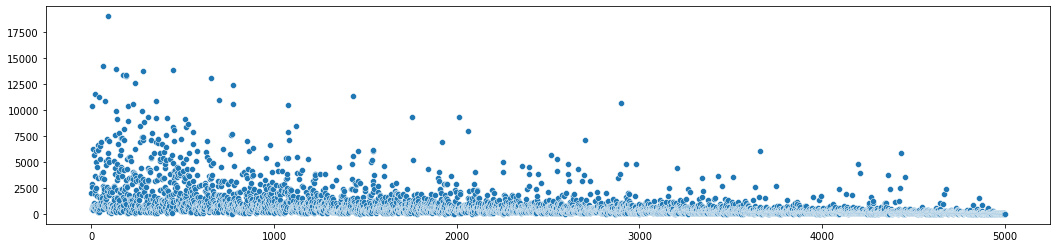

In [175]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_pure),show_graph=True)

=======analysis start=======
#all word size:  5000
#frequncy < 5:  2
#frequncy mean:  585.9322
#frequncy standard deviation:  1115.9149288378394
#frequncy std/mean:  1.9045120388294745


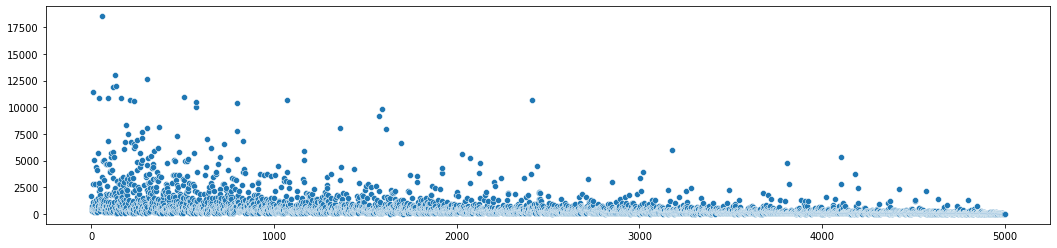

In [174]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_upper_max),show_graph=True)

In [179]:
skb_da_pure_limit = removeStopSememes(skb_da_pure,upper_limit=0.01,lower_limit=0)

=======analysis start=======
#all word size:  5000
#frequncy < 5:  0
#frequncy mean:  875.396
#frequncy standard deviation:  1449.2654401399352
#frequncy std/mean:  1.655554103674149


=======analysis start=======
#all word size:  4950
#frequncy < 5:  0
#frequncy mean:  780.4511111111111
#frequncy standard deviation:  1079.0451663596941
#frequncy std/mean:  1.3825916204071786


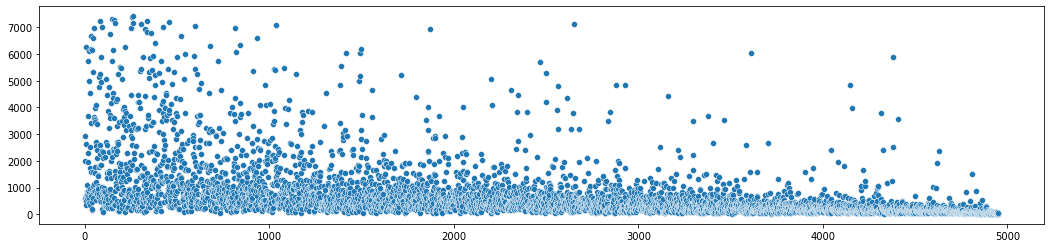

In [180]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_pure_limit),show_graph=True)

In [181]:
np.save(SKB_Benchmark_path+"/skb_da_pure_limit",skb_da_pure_limit)

## Function Definition

In [3]:
def clean_str(string,use=True):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    if not use: return string

    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [13]:
def load_stopwords(filepath):
    stopwords = set()
    with open(filepath, 'r') as f:
        for line in f:
            swd = line.strip()
            stopwords.add(swd)
    print(len(stopwords))
    return stopwords

In [5]:
def tf_idf_transform(inputs, mapping=None, sparse=False):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from scipy.sparse import coo_matrix
    vectorizer = CountVectorizer(vocabulary=mapping)
    tf_idf_transformer = TfidfTransformer()
    tf_idf = tf_idf_transformer.fit_transform(vectorizer.fit_transform(inputs))
    weight = tf_idf.toarray()
    return weight if not sparse else coo_matrix(weight)

In [6]:
def PMI(inputs, mapping, window_size, sparse):
    W_ij = np.zeros([len(mapping), len(mapping)], dtype=float)
    W_i = np.zeros([len(mapping)], dtype=float)
    W_count = 0
    for one in inputs:
        word_list = one.split(' ')
        if len(word_list) - window_size < 0:
            window_num = 1
        else:
            window_num = len(word_list) - window_size + 1

        for i in range(window_num):
            W_count += 1
            context = list(set(word_list[i:i + window_size]))
            while '' in context:
                context.remove('')
            for j in range(len(context)):
                W_i[mapping[context[j]]] += 1
                for k in range(j + 1, len(context)):
                    W_ij[mapping[context[j]], mapping[context[k]]] += 1
                    W_ij[mapping[context[k]], mapping[context[j]]] += 1

    if not sparse:
        PMI_adj = np.zeros([len(mapping), len(mapping)], dtype=np.float64)
        for i in range(len(mapping)):
            for j in range(len(mapping)):
                PMI_adj[i, j] = math.log(W_ij[i, j] * W_count / W_i[i] / W_i[j]) if W_ij[i, j] != 0 else 0
                if i == j: PMI_adj[i, j] = 1
                if PMI_adj[i, j] <= 0:
                    PMI_adj[i, j] = 0
    else:
        rows = []
        columns = []
        data = []
        for i in range(len(mapping)):
            for j in range(i, len(mapping)):
                value = math.log(W_ij[i, j] * W_count / W_i[i] / W_i[j]) if W_ij[i, j] != 0 else 0
                if i == j: value = 1
                if value > 0:
                    rows.append(i)
                    columns.append(j)
                    data.append(value)
                    if i != j:
                        rows.append(j)
                        columns.append(i)
                        data.append(value)
        PMI_adj = coo_matrix((data, (rows, columns)), shape=(len(mapping), len(mapping)))

    return PMI_adj

## Add Stopwords

In [21]:
def addStopWord(f_train, f_test, stop_word):
    word_freq = defaultdict(int)
    for item in f_train.values():
        words = clean_str(item['text']).split(' ')
        for one in words:
            word_freq[one.lower()] += 1
    for item in f_test.values():
        words = clean_str(item['text']).split(' ')
        for one in words:
            word_freq[one.lower()] += 1
    freq_stop = 0
    for word, count in word_freq.items():
        if count < 5:
            stop_word.add(word)
            freq_stop += 1
    stop_word.add('')
    print('freq_stop num',freq_stop)
    return stop_word

In [22]:
stop_word = addStopWord(train_dict, test_dict, load_stopwords(stopword_en_path))

398
freq_stop num 21098


In [23]:
len(stop_word)

21386

# Building Adjacency Matrix

## preprocession

In [103]:
def buildingAdj(all_data_dict, skb):
    adj_ent_index = []
    st_nodes = []
    tag_set = set()
    entity_set = set()
    words_set = set()
    all_idx = []
    labels = []
    tag_list = []
    word_list = []
    ent_mapping = {}
    
    for i, (sort_text, label) in enumerate(tqdm(all_data_dict.items())):
        sort_text = clean_str(sort_text)
        if not sort_text:
            print(sort_text)
            continue
        tags = [one[1].lower() for one in nltk.pos_tag(nltk.word_tokenize(sort_text))]
        if '' in tags: print("ERROR: ", item)
        tag_list.append(' '.join(tags))
        tag_set.update(tags)
        labels.append(label)
        words = [one.lower() for one in sort_text.split(' ') if one not in stop_word]
        if '' in words: print("ERROR: ", item)
        ent_list = []
        index = []
        ''' introduction skb '''
        for entity in skb.keys():
            if entity in words:
                ent_list.append(entity)
                if entity not in ent_mapping:
                    ent_mapping[entity] = len(ent_mapping)
                    entity_set.update(ent_list)
                if ent_mapping[entity] not in index: index.append(ent_mapping[entity])
        adj_ent_index.append(index)
        word_list.append(' '.join(words))
        words_set.update(words)
        if sort_text:
            st_nodes.append(sort_text)
        else:
            print("ERROR: ", i, sort_text)
        all_idx.append(len(all_idx))
    print("#tag_set", len(tag_set))
        
    multi_list = (all_idx, tag_list, word_list, labels)
    multi_set = (tag_set, entity_set, words_set)
    
    return st_nodes, ent_mapping, adj_ent_index, multi_list, multi_set

In [104]:
st_nodes, ent_mapping, adj_ent_index, multi_list, multi_set = buildingAdj(all_, skb_da_pure)

100%|██████████| 10171/10171 [39:12<00:00,  4.32it/s] 

#tag_set 34


In [108]:
word_nodes = list(multi_set[2])
tag_nodes = list(multi_set[0])
entity_nodes = list(multi_set[1])

In [110]:
nodes_all = st_nodes + tag_nodes + entity_nodes + word_nodes
nodes_num = len(st_nodes) + len(tag_nodes) + len(entity_nodes) + len(word_nodes)

In [112]:
print('st', len(st_nodes))
print('tag', len(tag_nodes))
print('ent', len(entity_nodes))
print('word', len(word_nodes))

st 10171
tag 34
ent 3801
word 4919


## ST to POS TF-IDF 

In [115]:
tags_mapping = {key: value for value, key in enumerate(tag_nodes)}

In [117]:
adj_st2tag = tf_idf_transform(multi_list[1], tags_mapping)

In [121]:
pkl.dump(adj_st2tag, open('{}/{}_over/adj_st2tag.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## POS to POS PMI

In [119]:
adj_tag = PMI(multi_list[1], tags_mapping, window_size=5, sparse=False)

In [122]:
pkl.dump(adj_tag, open('{}/{}_over/adj_tag.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## ST to Word TFIDF

In [ ]:
words_mapping = {key: value for value, key in enumerate(word_nodes)}

In [123]:
adj_st2word = tf_idf_transform(multi_list[2], words_mapping, sparse=True)

In [124]:
pkl.dump(adj_st2word, open('{}/{}_over/adj_st2word.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## Word to Word PMI

In [125]:
adj_word = PMI(multi_list[2], words_mapping, window_size=5, sparse=True)

In [126]:
pkl.dump(adj_word, open('{}/{}_over/adj_word.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))

## ST to Sememe TFIDF*SoftMax(LocalAttention)

In [156]:
ent_index_mapping = {index:word for word, index in ent_mapping.items()}

In [159]:
ent_list = [" ".join([ent_index_mapping[word_index] for word_index in sentence]) for sentence in adj_ent_index]

In [162]:
adj_st2ent = tf_idf_transform(ent_list, ent_mapping, sparse=True)

In [164]:
adj_st2ent.shape

(10171, 3801)

### chose the best sense of each word

In [182]:
def CosineSimilarity(x1, x2):
    x2 = x2.t()
    x = x1.mm(x2)
    x1_frobenius = x1.norm(dim=1).unsqueeze(0).t()
    x2_frobenins = x2.norm(dim=0).unsqueeze(0)
    x_frobenins = x1_frobenius.mm(x2_frobenins)
    final = x.mul(1/x_frobenins)
    return final
def localAttention(sentence_str, word_str, sememe_list, embedding_dict):
    '''
        input: sentence_str, word_str, embedding_dict
        oytput: word embedding
    '''
    #print(sentence_str, word_str)
    context_embedding_list = []
    sentence_list = sentence_str.split()
    if sentence_str != word_str:
        sentence_list.remove(word_str)
    for word in sentence_list:
        if word in embedding_dict.keys():
            context_embedding_list.append(embedding_dict[word])
        else:
            context_embedding_list.append([0.0]*300)

    context_embedding_list = torch.Tensor(context_embedding_list).to(device)
    word_embedding = torch.from_numpy(embedding_dict[word_str]).float().unsqueeze(0).to(device)
    #print(context_embedding_list.size(),word_embedding.size())
    cos_value_w = CosineSimilarity(context_embedding_list, word_embedding).to(device)
    softmax_nn = nn.Softmax(dim=0)
    softmax_weight_w = softmax_nn(cos_value_w) * 4
    '''
        get local word embedding
    '''
    local_word_embedding = softmax_weight_w.t().mm(context_embedding_list)
    
    
    sememes_embedding_list = []
    for sememe in sememe_list:
        if sememe in embedding_dict.keys():
            sememes_embedding_list.append(embedding_dict[sememe])
        else:
            sememes_embedding_list.append([0.0]*300)
            
    sememes_embedding_list = torch.Tensor(sememes_embedding_list).to(device)
    cos_value_s = CosineSimilarity(sememes_embedding_list, local_word_embedding).to(device)
    softmax_weight_s = softmax_nn(cos_value_s) * 2
    local_sememe_embedding = softmax_weight_s.t().mm(sememes_embedding_list)
    cos_value = CosineSimilarity(local_sememe_embedding,local_word_embedding)
    
    return cos_value.to('cpu').squeeze(0).numpy().tolist()

In [168]:
def replaceWord2Sememe(embedding_dict, skb_dict, docs_tuple,threshold,skb_cdv_map,ferquncy_max=0,overwrite=False):
    '''
        input: 
        process: if the word of sentence in skb && else if the freqency of word less then threshold:
                    replace the word to sememe:
                        if the sense of word only once:
                            straightforward replace else more thinking... of (sense dismatching- now leave aside)
                        else:
                            search the sentence embedding of docs by look-up embedding dictionary
                            for building the word embedding with weighted sum of sentence:
                                senses cosin = list
                                for index, sense the enumerate(senses):
                                    word cosin = list
                                    for sememe in sense:
                                        compare both that the embedding of the word and the sememe of the sense
                                        append the cosin value to word cosin list
                                    keep minimum of senses cosin to append the senses cosin list
                                get the index of minimum value for sense senses list
                                get the word via index with this word senses of SKB-DA
                            replace  
        return: docs list replaced with sememe
    '''
    sememe_docs_list = []

    '''
        threshold = np.mean(list(docs_tuple[0].values())) + np.std(list(word_freq.values())) /\
                np.mean(list(word_freq.values()))
    '''
    
    threshold = threshold
    ferquncy_max_word_list = [word for (word,_) in raw_word_freq_sorted[-round(ferquncy_max*len(docs_tuple[2])):]]
    for sentence in tqdm.tqdm(docs_tuple[2]):
        sentence_replace = []
        for word in sentence.split():
            #print("####",word)
            if word in skb_dict.keys() and (docs_tuple[0][word] < threshold or word in ferquncy_max_word_list):
                if len(skb_dict[word]) == 1:
                    if overwrite:
                        sentence_replace.append((["<S"+str(skb_cdv_map[sememe])+">" \
                                        for sememe in list(skb_dict[word][0][1])],  ))
                    else:
                        sentence_replace.append((skb_dict[word][0][1],  ))
                else:
                    if word not in embedding_dict.keys():
                        if overwrite:
                            sentence_replace.append((["<S"+str(skb_cdv_map[sememe])+">" \
                                              for sememe in list(skb_dict[word][0][1])],  ))
                        else:
                            sememe_disambiguation = []
                            for (pos, sememe_set) in skb_dict[word]:
                                if pos == 'disambiguation' or pos == 'NN' or pos == 'n':
                                    sememe_disambiguation.append(sememe_set)
                            sentence_replace.append((sememe_disambiguation[0],  ))
                    else:
                        senses_cos_list = []
                        for (_, sememe_set) in skb_dict[word]:
                            senses_cos_list.append(localAttention(\
                                                sentence, word, list(sememe_set), embedding_dict)[0])
                            #print(senses_cos_list)
                        if len(senses_cos_list) == 0:
                            sentence_replace.append(word)
                            continue
                        senses_cos_list_max_index = senses_cos_list.index(max(senses_cos_list))
                        if overwrite:
                            sentence_replace += ["<S"+str(skb_cdv_map[sememe])+">" \
                                              for sememe in list(skb_dict[word][senses_cos_list_max_index][1]) ]
                        else:
                            sentence_replace += list(skb_dict[word][senses_cos_list_max_index][1])          
            else:
                sentence_replace.append(word)
        sememe_docs_list.append(" ".join(sentence_replace))
    return sememe_docs_list

In [ ]:
def cleanBySKB(embedding_dict, skb_dict, doc_content_tuple, ferquncy_mix, skb_cdv_map, ferquncy_max):
    sememe_docs_list = replaceWord2Sememe(embedding_dict,\
                                      skb_dict,\
                                      doc_content_tuple,\
                                      ferquncy_mix,skb_cdv_map,ferquncy_max)
    clean_word_freq, clean_word_freq_sorted = evaluationFrequncy(sememe_docs_list,"Analysis of Ferquncy",ferquncy_mix)
    return (clean_word_freq, clean_word_freq_sorted,sememe_docs_list)

In [ ]:
localAttention(" ".join(['append','apple','book','red','foot']), 'apple', ['edible', 'fruit'], glove_840B_300d_common_crawl)

In [183]:
skb_da_pure['apple']

[('artwork', {'artist'}),
 ('disambiguation', {'edible', 'fruit'}),
 ('automobile', {'automobile', 'manufacture'}),
 ('NN',
  {'Eurasia',
   'Scandinavia',
   'crown',
   'early',
   'gymnosperm',
   'infer',
   'tart',
   'temperate',
   'zone'}),
 ('n', {'flesh', 'fruit', 'green', 'red', 'skin', 'sweet', 'tart', 'yellow'}),
 ('n',
  {'Eurasian', 'cultivate', 'edible', 'fruit', 'native', 'tree', 'variety'}),
 ('symbolism',
  {'annoyance',
   'folk',
   'hard-shelled',
   'irritation',
   'saddle',
   'sore',
   'tale',
   'tart',
   'telephone',
   'thorn'})]

In [ ]:
doc_content_tuple = cleanBySKB(glove_840B_300d_common_crawl,skb_da_pure,doc_content_tuple,5,skb_da_cdv_map)

## Sememe to Sememe cosin

## Save data of train + text

In [127]:
json.dump(multi_list[0], open('{}/{}_over/all_idx.json'.\
                              format(STC_Benchmark_path,dataset_name), 'w'), ensure_ascii=False)

## Save Label Map

In [128]:
label_map = {value: i for i, value in enumerate(set(multi_list[3]))}

In [130]:
json.dump([label_map[label] for label in multi_list[3]],\
          open('{}/{}_over/labels.json'.format(STC_Benchmark_path,dataset_name), 'w'),ensure_ascii=False)

##  Save Nodes

In [132]:
json.dump(st_nodes, open('{}/{}_over/st_id2_list.json'.\
                         format(STC_Benchmark_path,dataset_name), 'w'),ensure_ascii=False)

In [134]:
json.dump(tag_nodes, open('{}/{}_over/tag_id2_list.json'.\
                          format(STC_Benchmark_path,dataset_name), 'w'), ensure_ascii=False)

In [135]:
json.dump(word_nodes, open('{}/{}_over/word_id2_list.json'.\
                           format(STC_Benchmark_path,dataset_name), 'w'), ensure_ascii=False)

In [ ]:
#json.dump(entity_nodes, open('./{}_data/entity_id2_list.json'.format(dataset_name), 'w'),ensure_ascii=False)

## Save Embeddings for Word nodes

In [139]:
def getWordNodesEmbedding(word_nodes,embedding_dict):
    embs = []
    err_count = 0
    for word in word_nodes:
        if word in embedding_dict.keys():
            embs.append(embedding_dict[word])
        else:
            err_count += 1
            embs.append(np.zeros(300, dtype=np.float64))
    print('err in word count', err_count)
    return embs

In [140]:
word_nodes_embedding = getWordNodesEmbedding(word_nodes, glove_840B_300d_common_crawl)

err in word count 134


In [142]:
pkl.dump(np.array(word_nodes_embedding, dtype=np.float64),\
         open('{}/{}_over/word_emb.pkl'.format(STC_Benchmark_path,dataset_name), 'wb'))